In [35]:
import sqlite3
import pandas as pd

from utils import ( 
    normalize_session_col, 
    split_by_series, 
    plot_clusters,
    load_dataset
)
from tslearn.clustering import TimeSeriesKMeans

# Загрузка датасета

Обработал датасет стандартно, все дубликаты по `deal_id` удалены, взяты только `monthly`, два датасета сджойнены по `inner`. Для кластеризации важно нормализовать цены и количество покупок внутри одной сессии. Как оказалось после некоторого количества экспериментов здесь важно при нормализации делить на std (не всегда это что-то дает)

In [36]:
df = load_dataset("trade_info.sqlite3")

df = normalize_session_col(df, "price")
df = normalize_session_col(df, "lot_size")

Кластеризация уже реализована в `tslearn`, поэтому использую ее. В ней есть несколько метрик: `dtw, softdtw, euclidean`. Лучше всего работает `euclidean`. Кластера выходят лучше, если отфильтровать сессии с малым количеством покупок. Куда их отнести? Возможно, как обсуждалось на лекции, достаточно просто индикатора, что это выброс.

# Кластеризация

Датасет слишком маленький чтобы использовать какие-то методы подбора оптимального количества кластеров, по ним выходит, что их должно быть больше 30, тогда как сессий всего около 50. Так что кол-во кластеров выбраны на глаз. Визуально кластеры кажутся похожими, хотя что-то реально покупать по такому предсказанию я бы побоялся, если честно..

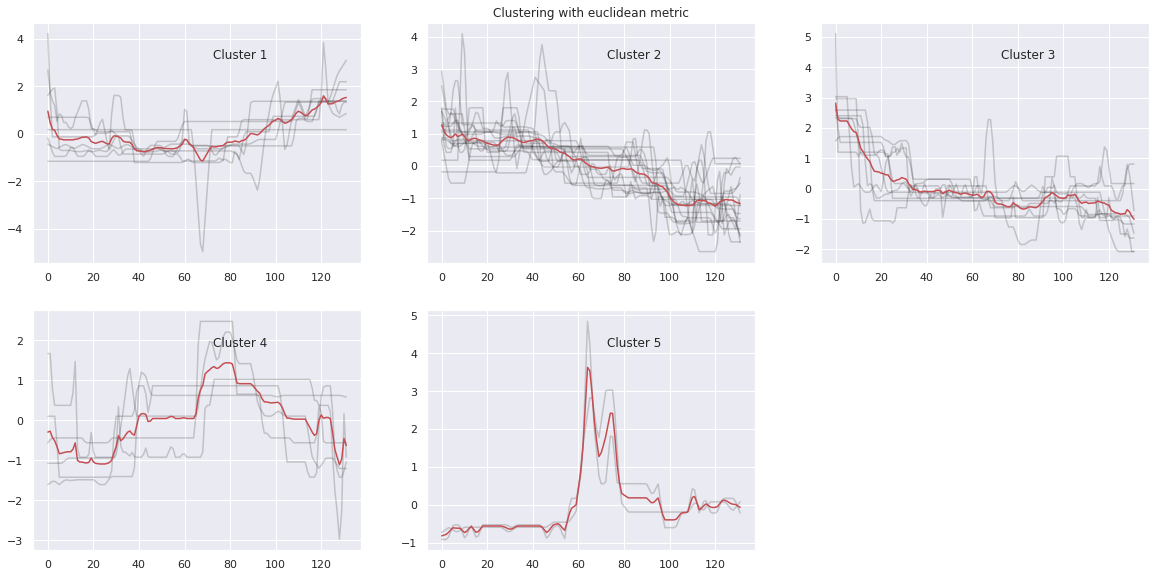

In [38]:
X = split_by_series(df, "price", count_thr=30, resample=True)

kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", random_state=2)
y = kmeans.fit_predict(X)

plot_clusters(X, y, n_clusters=5, estimator=kmeans, title="Clustering with euclidean metric")

Кластеризация по количество лотов выглядит менее осмысленной, хотя и наблюдаются какие-то общие для кластеров пики в определенное время.

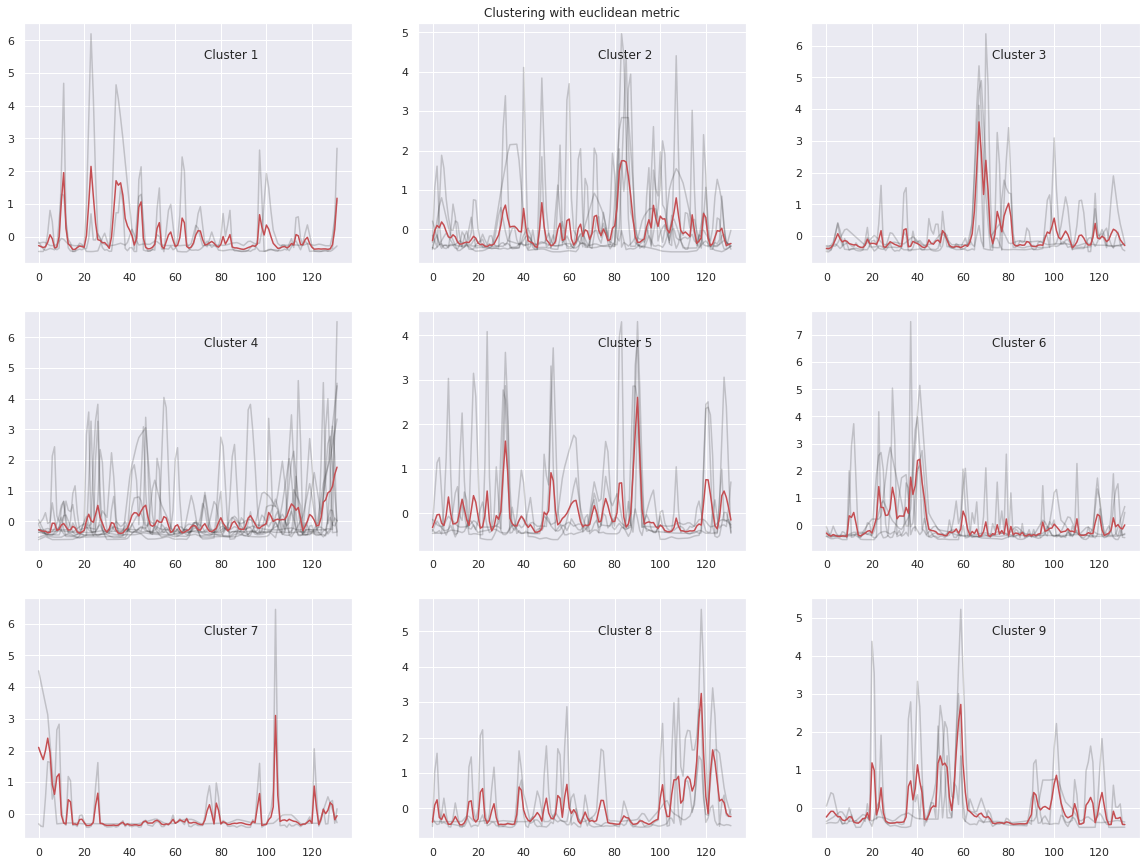

In [40]:
X = split_by_series(df, "lot_size", count_thr=30, resample=True)

kmeans = TimeSeriesKMeans(n_clusters=9, metric="euclidean", random_state=4)
y = kmeans.fit_predict(X)

plot_clusters(X, y, n_clusters=9, estimator=kmeans, title="Clustering with euclidean metric")

Можно попробовать кластеризовать отдельно по платформам, т.к. паттерн покупок для них по идее должен различаться. Кластеры получаются гораздо более однородными по паттернам, поэтому в реальной задаче я бы делал так.

### platform_id == 1

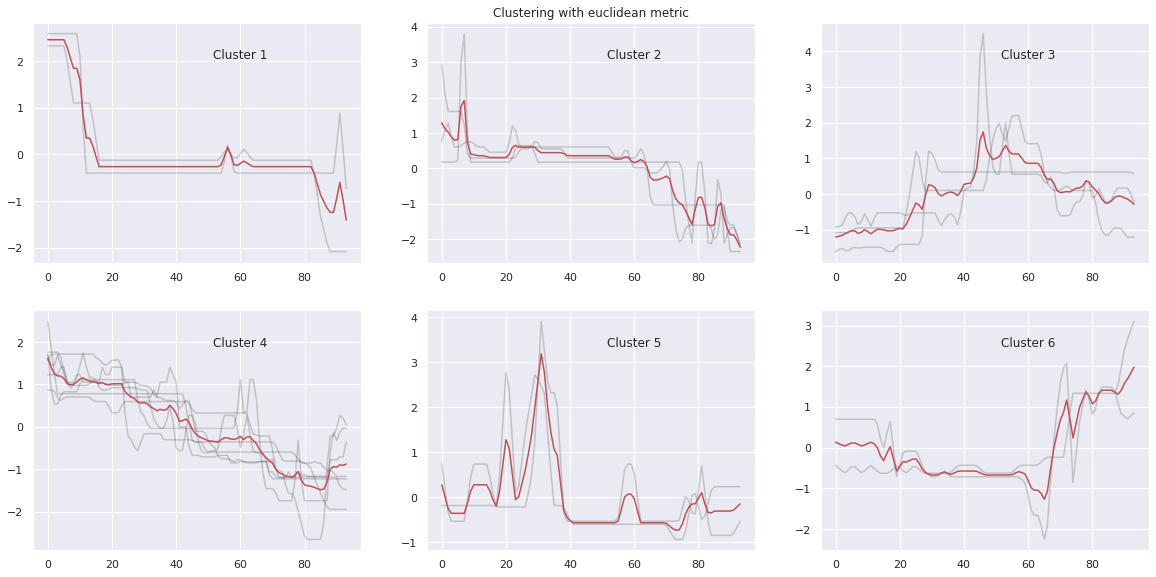

In [45]:
X = split_by_series(df[df.platform_id == 1], "price", count_thr=30, resample=True)

kmeans = TimeSeriesKMeans(n_clusters=6, metric="euclidean", random_state=2)
y = kmeans.fit_predict(X)

plot_clusters(X, y, n_clusters=6, estimator=kmeans, title="Clustering with euclidean metric")

# platform_id == 2

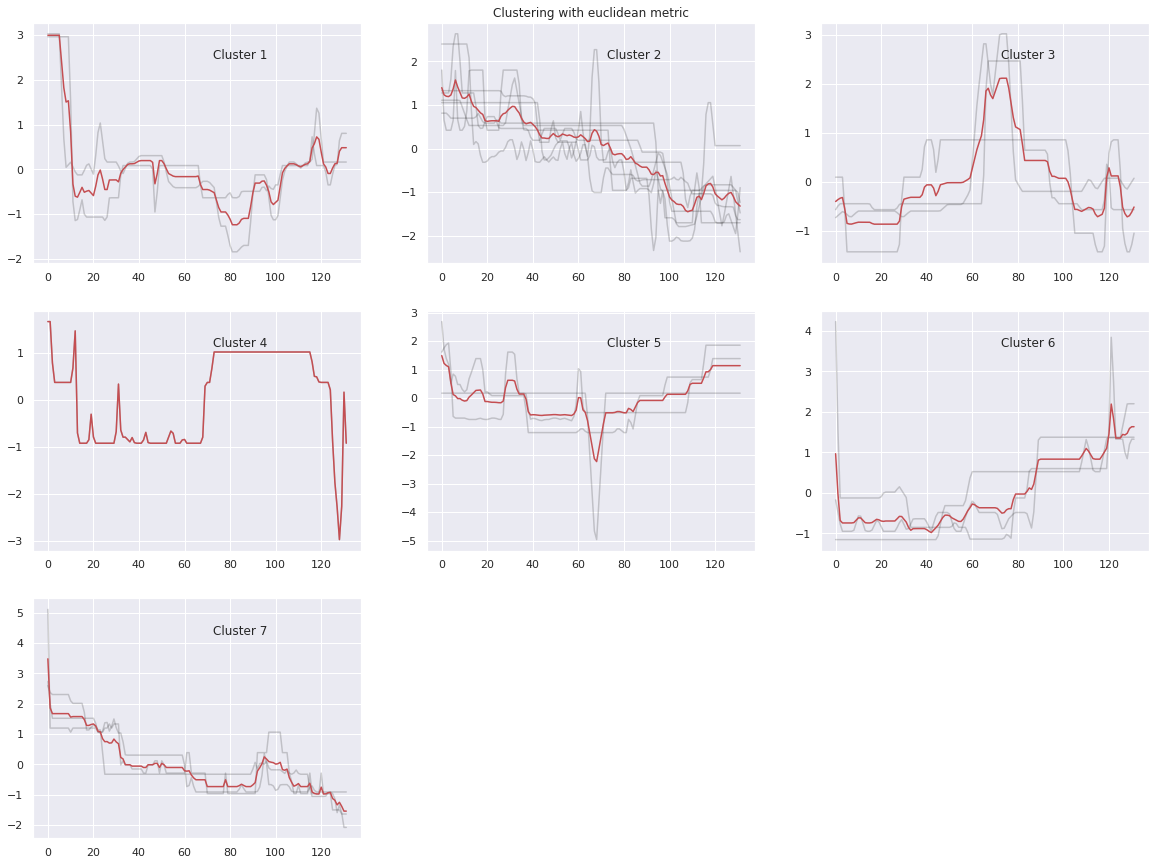

In [50]:
X = split_by_series(df[df.platform_id == 2], "price", count_thr=30, resample=True)

kmeans = TimeSeriesKMeans(n_clusters=7, metric="euclidean", random_state=1)
y = kmeans.fit_predict(X)

plot_clusters(X, y, n_clusters=7, estimator=kmeans, title="Clustering with euclidean metric")

Придумать хоть сколько-то адекватную интерпретацию подобным паттернам без знания предметной области и хоть какого-то описания датасета сложно. Для меня это выглядит как инженерная задача нахождения похожих линий.